# Análisis de tiempos de servicio

Este cuaderno ejecuta el flujo completo para parametrizar los tiempos de servicio:

1. Carga y limpieza básica de los datos por perfil.
2. Ajuste de regresiones lineales por combinación (priority, payment_method, day_type, lane_type).
3. Cálculo y clasificación de residuales (inliers/outliers) y ajuste de distribuciones.
4. Visualización de residuales clave.
5. Exportación de configuraciones para el simulador (inliers/outliers).
6. Evaluación de calidad y extracción de residuales para KDE cuando aplique.

In [13]:
# %% [markdown]
# 1. Carga de datos y configuración

import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from scipy import stats

# Rutas y perfiles
PERFILES_DIR = Path('perfiles')
PROFILE_FILES = {
    'Family Cart': PERFILES_DIR / 'customers_family_cart.csv',
    'Deal Hunter': PERFILES_DIR / 'customers_deal_hunter.csv',
    'Express Basket': PERFILES_DIR / 'customers_express_basket.csv',
    'Regular': PERFILES_DIR / 'customers_regular.csv',
    'Self Checkout Fan': PERFILES_DIR / 'customers_self_checkout_fan.csv',
    'Weekly Planner': PERFILES_DIR / 'customers_weekly_planner.csv',
}

def get_day_type(source_folder: str) -> str:
    day = int(source_folder.split('-Day-')[1])
    if day in [1, 2, 4]:
        return 'Tipo 1'
    if day in [3, 5, 6]:
        return 'Tipo 2'
    return 'Tipo 3'


dataframes = []
dataframe_labels = []
for label, file_path in PROFILE_FILES.items():
    if not file_path.exists():
        raise FileNotFoundError(f'No se encontró {file_path}')
    df = pd.read_csv(file_path)
    df['day_type'] = df['source_folder'].apply(get_day_type)
    dataframes.append(df)
    dataframe_labels.append(label)

summary = []
for label, df in zip(dataframe_labels, dataframes):
    summary.append({
        'profile': label,
        'rows': df.shape[0],
        'service_time_nulls': df['service_time_s'].isna().sum(),
        'items_min': df['items'].min(),
        'items_max': df['items'].max(),
    })
print('Perfiles cargados:', dataframe_labels)
display(pd.DataFrame(summary))

C:\Users\alvar\AppData\Local\Temp\ipykernel_37376\782484335.py:40: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\alvar\AppData\Local\Temp\ipykernel_37376\782484335.py:40: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Perfiles cargados: ['Family Cart', 'Deal Hunter', 'Express Basket', 'Regular', 'Self Checkout Fan', 'Weekly Planner']


,profile,rows,service_time_nulls,items_min,items_max
0,Family Cart,213234,46505,3,300
1,Deal Hunter,256536,39810,1,119
2,Express Basket,404182,21373,1,59
3,Regular,228938,45651,1,158
4,Self Checkout Fan,132008,6466,1,60
5,Weekly Planner,221765,54793,1,288


In [14]:
# %% [markdown]
# 2. Ajuste de regresiones y distribuciones de residuales

dedicated_factors = ['priority', 'payment_method', 'day_type', 'lane_type']
MIN_OBS = 30
SIGMA_CLIP = 3.0
CLEAN_QUANTILES = (0.01, 0.99)


def _available_factors(df: pd.DataFrame):
    return [col for col in dedicated_factors if col in df.columns]


def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    out = df.dropna(subset=['items', 'service_time_s']).copy()
    out = out[out['items'] >= 0]
    out = out[out['service_time_s'] >= 0]
    if not out.empty:
        lo, hi = out['service_time_s'].quantile(CLEAN_QUANTILES)
        out = out[(out['service_time_s'] >= lo) & (out['service_time_s'] <= hi)]
    return out


def fit_linear_regression(subset: pd.DataFrame):
    X = sm.add_constant(subset['items'])
    model = sm.OLS(subset['service_time_s'], X).fit()
    fitted = model.predict(X)
    residuals = subset['service_time_s'] - fitted
    summary = {
        'alpha': float(model.params['const']),
        'beta': float(model.params['items']),
        'alpha_ci_low': float(model.conf_int().loc['const', 0]),
        'alpha_ci_high': float(model.conf_int().loc['const', 1]),
        'beta_ci_low': float(model.conf_int().loc['items', 0]),
        'beta_ci_high': float(model.conf_int().loc['items', 1]),
        'p_value': float(model.pvalues['items']),
        'r2': float(model.rsquared),
        'n_obs': int(subset.shape[0]),
    }
    return summary, fitted, residuals


def classify_residuals(residuals: pd.Series) -> pd.Series:
    std = residuals.std(ddof=1)
    if not np.isfinite(std) or std == 0:
        std = 1.0
    z = residuals / std
    return z.abs() <= SIGMA_CLIP


def fit_residual_distribution(residuals: pd.Series):
    distributions = {
        'normal': stats.norm,
        'lognorm': stats.lognorm,
        't': stats.t,
    }
    results = []
    data = residuals.values
    for name, dist in distributions.items():
        try:
            params = dist.fit(data, floc=0) if name == 'lognorm' else dist.fit(data)
            loglik = np.sum(dist.logpdf(data, *params))
            k = len(params)
            aic = 2 * k - 2 * loglik
            ks_stat, ks_p = stats.kstest(data, name, args=params)
            results.append({
                'distribution': name,
                'params': params,
                'loglik': loglik,
                'aic': aic,
                'ks_stat': ks_stat,
                'ks_p': ks_p,
            })
        except Exception as exc:
            results.append({
                'distribution': name,
                'params': (),
                'loglik': np.nan,
                'aic': np.nan,
                'ks_stat': np.nan,
                'ks_p': np.nan,
                'error': str(exc),
            })
    results_df = pd.DataFrame(results)
    best_row = None
    if not results_df['aic'].isna().all():
        best_row = results_df.loc[results_df['aic'].idxmin()]
    return results_df, best_row


def analyze_profile(label: str, df: pd.DataFrame):
    cleaned = basic_clean(df)
    factors = _available_factors(cleaned)
    if not factors:
        return [], [], []
    groups = cleaned.groupby(factors, dropna=False)
    regression_rows = []
    residual_rows = []
    dist_rows = []
    for keys, group in groups:
        if group.shape[0] < MIN_OBS or group['items'].nunique() < 2:
            continue
        summary, fitted, residuals = fit_linear_regression(group)
        keep_mask = classify_residuals(residuals)
        inliers = residuals[keep_mask]
        outliers = residuals[~keep_mask]
        keys_dict = dict(zip(factors, keys if isinstance(keys, tuple) else (keys,)))
        base_row = {'profile': label}
        for factor in dedicated_factors:
            base_row[factor] = keys_dict.get(factor)
        regression_row = {**base_row, **summary,
                          'inlier_count': int(inliers.shape[0]),
                          'outlier_count': int(outliers.shape[0])}
        if not inliers.empty:
            dist_full, best = fit_residual_distribution(inliers)
            dist_full['profile'] = label
            for factor in dedicated_factors:
                dist_full[factor] = keys_dict.get(factor)
            dist_rows.append(dist_full)
            if best is not None:
                regression_row.update({
                    'best_residual_dist': best['distribution'],
                    'best_residual_params': tuple(best['params']),
                    'best_residual_aic': best['aic'],
                    'best_residual_ks_p': best['ks_p'],
                })
        else:
            regression_row.update({
                'best_residual_dist': None,
                'best_residual_params': (),
                'best_residual_aic': np.nan,
                'best_residual_ks_p': np.nan,
            })
        regression_rows.append(regression_row)
        residual_rows.append(pd.DataFrame({
            **base_row,
            'service_time_s': group['service_time_s'].values,
            'fitted': fitted,
            'residual': residuals,
            'is_inlier': keep_mask,
        }))
    return regression_rows, residual_rows, dist_rows


regression_results = []
residual_dfs = []
distribution_results = []
for label, df in zip(dataframe_labels, dataframes):
    reg_rows, res_rows, dist_rows = analyze_profile(label, df)
    regression_results.extend(reg_rows)
    residual_dfs.extend(res_rows)
    distribution_results.extend(dist_rows)

regression_summary_df = pd.DataFrame(regression_results)
if not regression_summary_df.empty:
    for col, default in [('best_residual_dist', None), ('best_residual_params', tuple()), ('best_residual_aic', np.nan), ('best_residual_ks_p', np.nan)]:
        if col not in regression_summary_df.columns:
            regression_summary_df[col] = default

residuals_df = pd.concat(residual_dfs, ignore_index=True) if residual_dfs else pd.DataFrame()
residual_dist_df = pd.concat(distribution_results, ignore_index=True) if distribution_results else pd.DataFrame()

print('Regresiones calculadas:', regression_summary_df.shape)
print('Observaciones residuales:', residuals_df.shape)
print('Distribuciones residuales:', residual_dist_df.shape)

display(regression_summary_df.head())

Regresiones calculadas: (350, 20)
Observaciones residuales: (1216546, 9)
Distribuciones residuales: (1050, 12)


,profile,priority,payment_method,day_type,lane_type,alpha,beta,alpha_ci_low,alpha_ci_high,beta_ci_low,beta_ci_high,p_value,r2,n_obs,inlier_count,outlier_count,best_residual_dist,best_residual_params,best_residual_aic,best_residual_ks_p
0,Family Cart,no_priority,card,Tipo 1,regular,54.974582,3.138629,52.324119,57.625046,3.107929,3.169329,0.000000,0.569224,30390,29964,426,t,"(7.300830855077503, -6.280332752403785, 69.271...",347479.384692,1.104335e-21
1,Family Cart,no_priority,card,Tipo 1,self_checkout,82.525056,2.479540,0.695495,164.354616,-3.513391,8.472472,0.405613,0.021714,34,34,0,t,"(9664422.093800358, -0.0010917272595724649, 26...",326.184640,2.177626e-01
2,Family Cart,no_priority,card,Tipo 2,regular,54.304350,3.136834,51.516496,57.092203,3.104549,3.169119,0.000000,0.572133,27125,26738,387,t,"(7.047054284975874, -5.945525630796997, 68.360...",309641.015961,1.771444e-14
3,Family Cart,no_priority,card,Tipo 3,regular,54.266073,3.144658,50.681172,57.850974,3.103298,3.186018,0.000000,0.572273,16602,16364,238,t,"(6.945906381694628, -6.500037241342426, 67.995...",189403.104337,1.046230e-08
4,Family Cart,no_priority,card,Tipo 3,self_checkout,132.236940,-1.358701,73.458848,191.015032,-5.750004,3.032601,0.531817,0.013620,31,31,0,t,"(170628891.62527025, -9.097902469263242e-05, 1...",274.493381,9.325290e-01


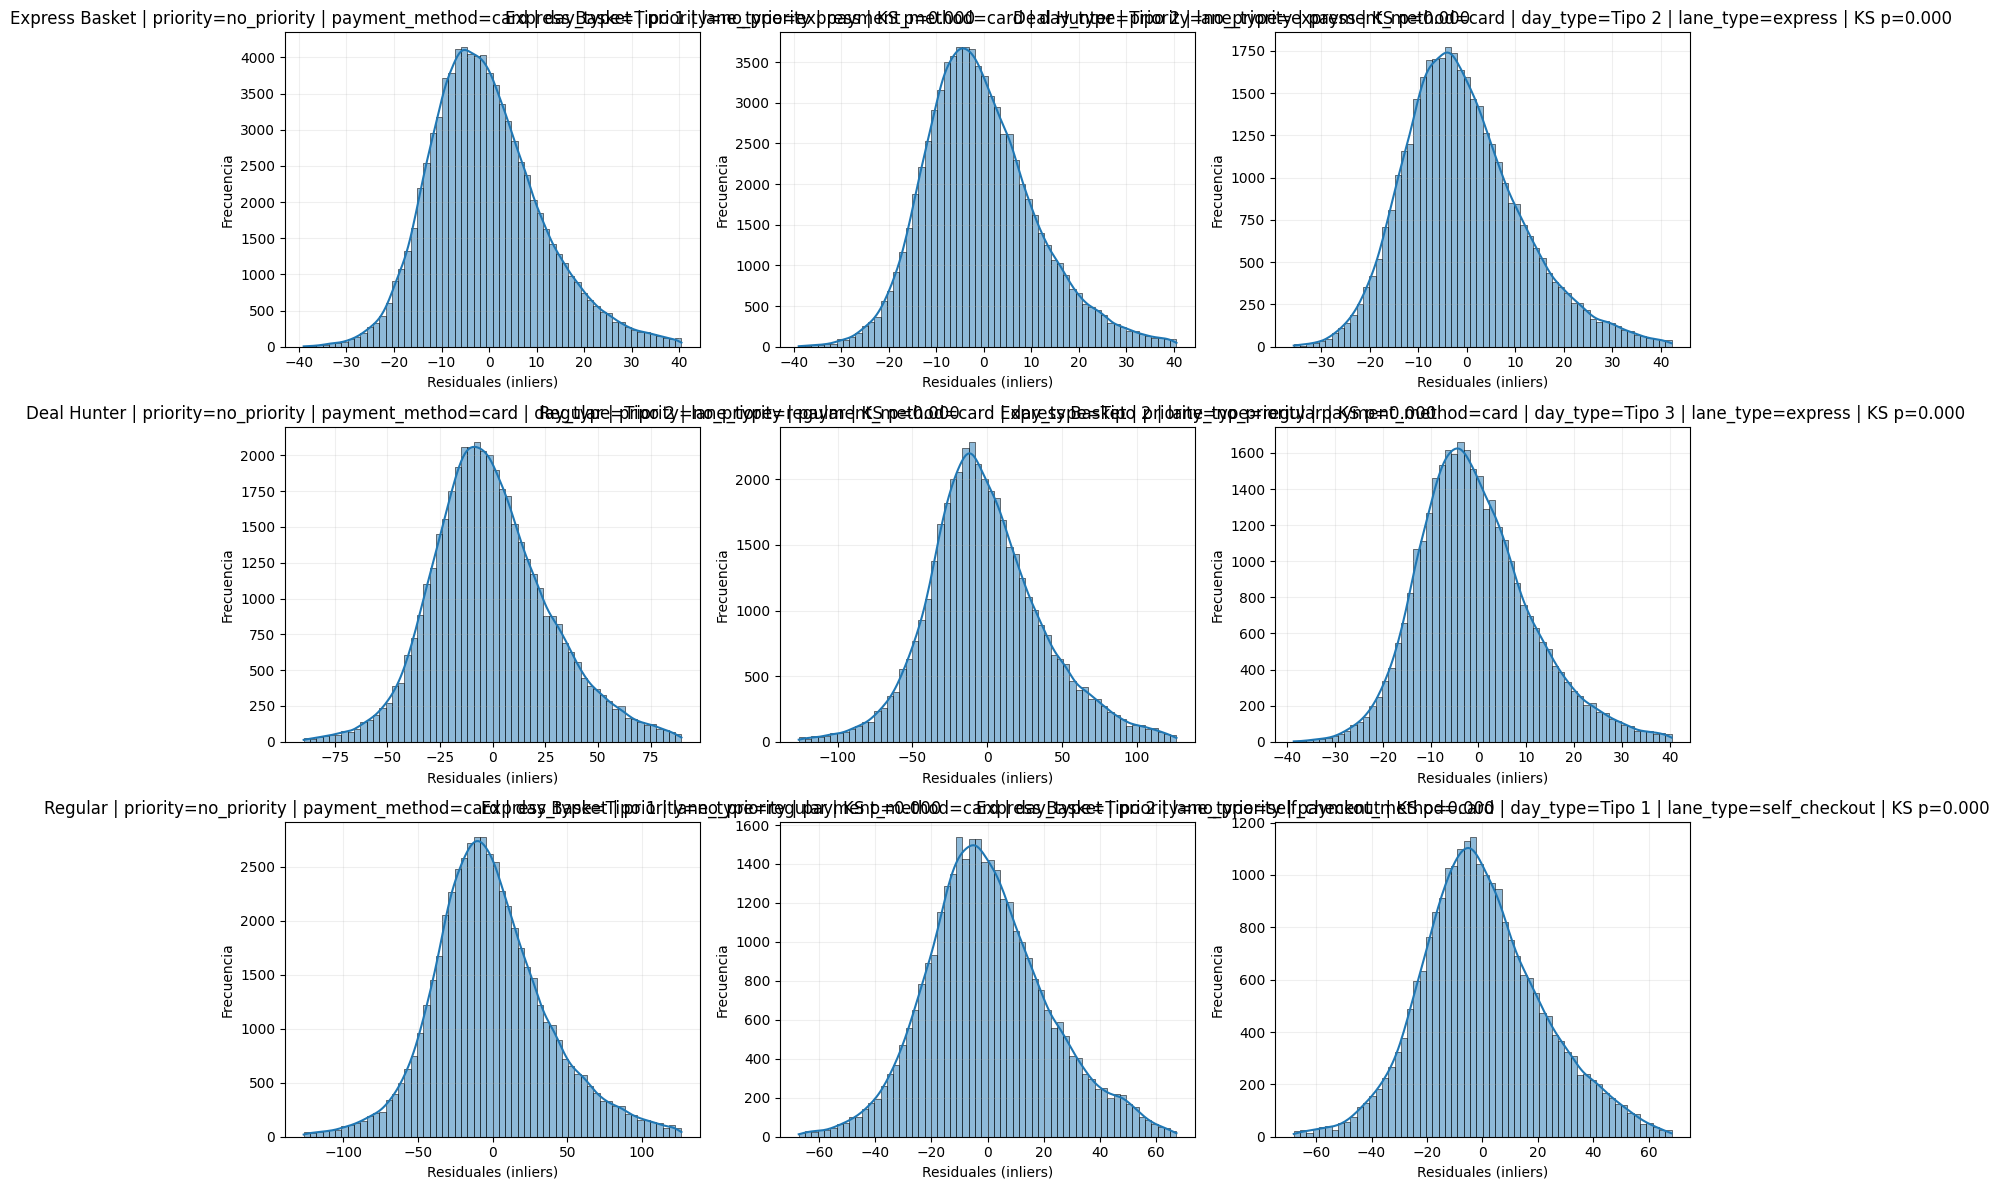

In [15]:
# %% [markdown]
# 3. Visualización de residuales (inliers)

if residuals_df.empty:
    print('Sin residuales para graficar. Ejecuta la celda anterior.')
else:
    plot_candidates = regression_summary_df.copy()
    if 'best_residual_ks_p' not in plot_candidates.columns:
        plot_candidates['best_residual_ks_p'] = 1.0
    plot_candidates['best_residual_ks_p'] = plot_candidates['best_residual_ks_p'].fillna(1.0)
    plot_candidates = plot_candidates.sort_values('best_residual_ks_p')
    top = plot_candidates.head(min(9, plot_candidates.shape[0]))
    if top.empty:
        print('No hay combinaciones suficientes para graficar.')
    else:
        n = top.shape[0]
        ncols = 3 if n >= 9 else 2 if n >= 4 else 1
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4), squeeze=False)
        axes_flat = axes.flatten()
        for ax, (_, row) in zip(axes_flat, top.iterrows()):
            mask = residuals_df['profile'] == row['profile']
            for factor in dedicated_factors:
                if factor in residuals_df.columns:
                    mask &= residuals_df[factor] == row.get(factor)
            subset = residuals_df[mask & residuals_df['is_inlier']]
            if subset.empty:
                ax.set_axis_off()
                continue
            sns.histplot(subset['residual'], bins=60, kde=True, ax=ax)
            title_parts = [row['profile']]
            for factor in dedicated_factors:
                if factor in row:
                    title_parts.append(f"{factor}={row[factor]}")
            ks_val = row.get('best_residual_ks_p', float('nan'))
            title_parts.append(f"KS p={ks_val:.3f}" if np.isfinite(ks_val) else 'KS p=NA')
            ax.set_title(' | '.join(title_parts))
            ax.set_xlabel('Residuales (inliers)')
            ax.set_ylabel('Frecuencia')
            ax.grid(alpha=0.2)
        for ax in axes_flat[len(top):]:
            ax.set_axis_off()
        fig.tight_layout()
        plt.show()

In [16]:
# %% [markdown]
# 5. Evaluación de calidad de ajuste y candidatos a KDE

R2_THRESHOLD = 0.2
KS_THRESHOLD = 0.05
MIN_INLIERS_KDE = 40

if regression_summary_df.empty or residuals_df.empty:
    print('Ejecuta la celda de regresión antes de evaluar la calidad.')
else:
    key_cols = ['profile'] + [col for col in dedicated_factors if col in regression_summary_df.columns]
    quality_df = regression_summary_df.copy()
    if 'best_residual_ks_p' not in quality_df.columns:
        quality_df['best_residual_ks_p'] = np.nan
    quality_df['weak_r2'] = quality_df['r2'] < R2_THRESHOLD
    quality_df['poor_ks'] = quality_df['best_residual_ks_p'].fillna(0) < KS_THRESHOLD
    quality_df['kde_candidate'] = quality_df['poor_ks'] & (quality_df['inlier_count'] >= MIN_INLIERS_KDE)

    print('Total combinaciones evaluadas:', quality_df.shape[0])
    print(f"Regresiones con R² < {R2_THRESHOLD}:", int(quality_df['weak_r2'].sum()))
    print(f"Distribuciones residuales con KS p < {KS_THRESHOLD}:", int(quality_df['poor_ks'].sum()))
    print('Candidatas a KDE:', int(quality_df['kde_candidate'].sum()))

    quality_path = Path('service_time/service_time_quality_report.csv')
    quality_df.to_csv(quality_path, index=False)
    print('Reporte de calidad exportado a', quality_path)

    kde_candidates = quality_df[quality_df['kde_candidate']]
    if kde_candidates.empty:
        print('Sin residuales para KDE (no hay candidatas).')
    else:
        merge_cols = [col for col in key_cols if col in residuals_df.columns]
        residuals_inliers = residuals_df[residuals_df['is_inlier']].copy()
        residuals_for_kde = residuals_inliers.merge(kde_candidates[merge_cols], on=merge_cols, how='inner')
        kde_path = Path('service_time/service_time_kde_residuals.csv')
        residuals_for_kde[['profile'] + [col for col in dedicated_factors if col in residuals_for_kde.columns] + ['residual']].to_csv(kde_path, index=False)
        print('Residuales para KDE exportados a', kde_path, 'con', residuals_for_kde.shape[0], 'filas')

Total combinaciones evaluadas: 350
Regresiones con R² < 0.2: 71
Distribuciones residuales con KS p < 0.05: 74
Candidatas a KDE: 74
Reporte de calidad exportado a service_time\service_time_quality_report.csv
Residuales para KDE exportados a service_time\service_time_kde_residuals.csv con 1109814 filas


In [17]:
# %% [markdown]
# 6. Exportación final de configuraciones para el simulador (post-KDE)

def _unpack_params(dist_name, params):
    params = params or ()
    mapping = {}
    if dist_name == 'normal' and len(params) >= 2:
        mapping['loc'] = float(params[0])
        mapping['scale'] = float(params[1])
    elif dist_name == 'lognorm' and len(params) >= 3:
        mapping['shape'] = float(params[0])
        mapping['loc'] = float(params[1])
        mapping['scale'] = float(params[2])
    elif dist_name == 't' and len(params) >= 3:
        mapping['df'] = float(params[0])
        mapping['loc'] = float(params[1])
        mapping['scale'] = float(params[2])
    else:
        for i, value in enumerate(params):
            mapping[f'param_{i}'] = float(value)
    return mapping

if regression_summary_df.empty:
    print('Ejecuta la celda de regresión antes de exportar.')
else:
    key_cols = ['profile'] + [col for col in dedicated_factors if col in regression_summary_df.columns]
    inlier_records = []
    for _, row in regression_summary_df.iterrows():
        rec = {col: row.get(col) for col in key_cols}
        rec.update({
            'alpha': row['alpha'],
            'beta': row['beta'],
            'alpha_ci_low': row['alpha_ci_low'],
            'alpha_ci_high': row['alpha_ci_high'],
            'beta_ci_low': row['beta_ci_low'],
            'beta_ci_high': row['beta_ci_high'],
            'p_value': row['p_value'],
            'r2': row['r2'],
            'n_obs': row['n_obs'],
            'inlier_count': row['inlier_count'],
            'outlier_count': row['outlier_count'],
            'residual_distribution': row.get('best_residual_dist'),
            'residual_aic': row.get('best_residual_aic'),
            'residual_ks_p': row.get('best_residual_ks_p'),
        })
        rec.update(_unpack_params(row.get('best_residual_dist'), row.get('best_residual_params')))
        inlier_records.append(rec)
    inliers_summary_df = pd.DataFrame(inlier_records)

    outliers_summary_records = []
    if not residuals_df.empty and residuals_df['is_inlier'].eq(False).any():
        outlier_subset = residuals_df[~residuals_df['is_inlier']].copy()
        group_cols = key_cols
        grouped = outlier_subset.groupby(group_cols, dropna=False)
        for keys, group in grouped:
            dist_df, best = fit_residual_distribution(group['residual'])
            keys_dict = dict(zip(group_cols, keys if isinstance(keys, tuple) else (keys,)))
            record = {col: keys_dict.get(col) for col in group_cols}
            record['outlier_count'] = int(group.shape[0])
            record['residual_mean'] = float(group['residual'].mean())
            record['residual_std'] = float(group['residual'].std(ddof=1))
            if best is not None:
                record['residual_distribution'] = best['distribution']
                record['residual_aic'] = best['aic']
                record['residual_ks_p'] = best['ks_p']
                record.update(_unpack_params(best['distribution'], best['params']))
            else:
                record['residual_distribution'] = None
                record['residual_aic'] = np.nan
                record['residual_ks_p'] = np.nan
            outliers_summary_records.append(record)
    outliers_summary_df = pd.DataFrame(outliers_summary_records)

    output_dir = Path('service_time')
    output_dir.mkdir(exist_ok=True)
    inliers_path = output_dir / 'service_time_inliers_summary.csv'
    inliers_summary_df.to_csv(inliers_path, index=False)
    print('Inliers exportados a', inliers_path)

    outliers_path = output_dir / 'service_time_outliers_summary.csv'
    if outliers_summary_df.empty:
        if outliers_path.exists():
            outliers_path.unlink()
        print('No se exportó archivo de outliers (sin registros).')
    else:
        outliers_summary_df.to_csv(outliers_path, index=False)
        print('Outliers exportados a', outliers_path)

C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2068: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2068: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2068: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_distn_in

Inliers exportados a service_time\service_time_inliers_summary.csv
Outliers exportados a service_time\service_time_outliers_summary.csv
